# Testing basic ML algorithms in 2d 


In [ ]:
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt
import pandas as pd

# Simple generation exercise

Divide a 2-d space in two regions based on a function of the two variables, 
and populate the two regions with randomly distributed points 

In [ ]:
def generate_samples(n=10000):
 # generate random inputs in [-0.5, 0.5]
 X1 = np.random.random(n)-0.5
 X2 = np.random.random(n)-0.5
# X3 = X1*0.2+X2*0.3<0
# X3=((X1<0) & (X2<0)) | ((X1>0.25) & (X2>0.25))
 X3=X1*X1*0.3-X2*0.2>0
# X3=X1*X1*0.3-X2*0.2>0
# define labelling as a logical function
# stacking requires vectors to be defined as 2-d vector with
# second dimension=1
 X1 = X1.reshape(n, 1)
 X2 = X2.reshape(n, 1)
 X3 = X3.reshape(n, 1)
# print(X1)
# print(X2)
# print(X3)
 data= np.hstack((X1, X2, X3))
# print(data)
 return pd.DataFrame(data,columns=['x1', 'x2','SIG'])

Visualise generated patterns in 2-d parameter space

In [ ]:
def plot_scat(df, sel1, sel2, var1, var2, blx, bhx, bly, bhy):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  fig= plt.figure(figsize=(14,5))
  plt.subplot(1, 2,1)
  plt.xlim([blx,bhx])
  plt.ylim([bly,bhy])
  plt.plot(df_nopass[var1], df_nopass[var2], 'bo', alpha=0.4, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.subplot(1, 2,2)
  plt.xlim([blx,bhx])
  plt.ylim([blx,bhx])
  plt.plot(df_pass[var1], df_pass[var2], 'ro', alpha=0.4, label=sel1)
  plt.legend(loc='best')
  plt.xlabel(var1)
  plt.ylabel(var2)
  plt.show()

## Run generation

In [ ]:
df = generate_samples()
sel1='SIG==0'
sel2='SIG==1'
plot_scat(df, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)

# Set of  standard diagnostic methods to understand the performance of the  classification algorithms

## Simple wrapper for histogramming a variable from the dataframe

In [ ]:
# in input:  df=dataframe var=variable in dataframe, 
# scale=scale factor on value of variable (e.g. for scaling between MeV and GeV)
# nbin,xlow,xhigh: limits of histogram
# norm: choose whether you plot acutal number of events in bin or fraction of events 
#       in each bin with respect to total
# labx, laby labels of x and y axis of histogram 
# title: title of hisotgram
# leg: legenda for content, useful if you superimpose two hists
def hist1d(df, var, scale, nbin, xlow, xhig, norm, labx, laby, title, leg):
  bins = np.linspace(xlow,xhig,nbin)
  plt.hist(df[var]*scale, bins, alpha=0.5, density=norm, label=leg)
  plt.xlabel(labx)
  plt.ylabel(laby)
  plt.legend(loc='best')
# 2d, same definition of inputs as above
def hist2d(df,var1,var2,scalex,scaley,nbinx,xlow,xhig,nbiny,ylow,yhig,labx,laby,title):
  binx = np.linspace(xlow,xhig,nbinx)
  biny = np.linspace(ylow,yhig,nbiny)
  plt.hist2d(df[var1]*scalex, df[var2]*scaley, bins=[binx, biny], density=False, cmin=0.5)
  plt.xlabel(labx)
  plt.ylabel(laby)

## Plot history of losses along epochs for Keras

In [ ]:
import matplotlib.pyplot as plt

# plot the  history 
def plothis(history, title):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#  plt.show()

def plothis_file(filehis, title):
  hh = pd.read_csv(filehis, header=0, engine='python')   
  plt.plot(hh['loss'].values)
  plt.plot(hh['val_loss'].values)
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
#plothis(history, 'test network')

## Plot distribution of output probabilities  for signal and backround

The output of the classification is for each event a number between 0 and 1 representing the probability that that event is a signal event. Since for each event we know whether it was a signal (SIG=1) or a background (SIG=0), we can plot the output probability of the network for each of the two classes.


In [ ]:

def plot_prob(y_test, Ypredt):

#build a dataframe with as columns the output PROB and the label (SIG)

  df_test_acc = pd.DataFrame({'PROB':Ypredt[:,0]})
  df_test_acc['SIG']=y_test

# split according to the label
  df_test_acc_bkg = df_test_acc.query('SIG==0')
  df_test_acc_sig = df_test_acc.query('SIG==1')
  print('nsig ',df_test_acc_sig.shape[0])
  print('nbkg ',df_test_acc_bkg.shape[0])
  bins = np.linspace(0, 1,50)
  plt.hist(df_test_acc_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
  plt.hist(df_test_acc_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
  plt.legend(loc='best')
  plt.show()

## Plot ROC curve and calculate AUC
In order to perform our the final selection we put a lower limit on the value of the probability and we count the fraction of events above this limit for both signal and backround, i.e for each value of PROB we have two values: The 'true positive rate (TPR)' (efficiency of signal selection in HEP language), and 'false positive rate (FPR)' (efficency for selecting background). If we TPR versus FPR the other as a function of PROB we obtain a curve called the Receive Operating Characteristic (ROC) curve https://en.wikipedia.org/wiki/Receiver_operating_characteristic. Methods for building the ROC curve are availabel in sklearn.metrics. An ideal ROC curve would be along upper x and left y axes of the plot, corresponding to the case where all of the signal events have PROB=1 and all background events have PROB=0. The worst case is a curve where TPR=FPR, i.e. the discrimination power is the same as extracting a random number for PROB.

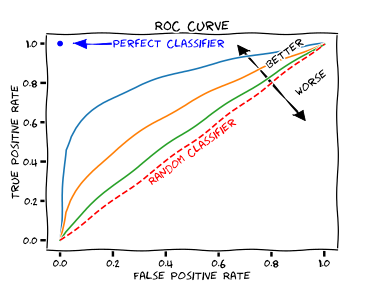


A measure of how near the ideal our ROC curve is is the 'area under the curve' (AUC), which is also available in sklearn metrics. The ideal case would have AUC=1 and th worst case AUC=0.5

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

def plot_roc_base(y_test, Ypredt, labroc):
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, Ypredt)
  auc_keras = auc(fpr_keras, tpr_keras)
  print(labroc," auc ",auc_keras)
  plt.plot(fpr_keras, tpr_keras, label=labroc+' AUC = {:.3f}'.format(auc_keras))

def plot_roc_single(y_test, Ypredt, labroc):
   plt.plot([0.001, 1], [0, 1], 'k--')
   plot_roc_base(y_test, Ypredt, labroc)
   plt.xlabel('False positive rate')
   plt.ylabel('True positive rate')
   plt.legend(loc='best')
   plt.show    


## Plot distributions of variables for accepted and rejected events

In order to understand what the ML algorithm  does, it can be useful to plot the distribution of the variables for accepted and rejected events, and their correlations.


In [ ]:
def plot_varsel(df, sel1, sel2, var, blow, bhigh, nbin):
  df_pass = df.query(sel1)
  df_nopass = df.query(sel2)
  bins = np.linspace(blow, bhigh, nbin)
  plt.hist(df_pass[var], bins, alpha=0.5, density=True, label=sel1)
  plt.hist(df_nopass[var], bins, alpha=0.5, density=True, label=sel2)
  plt.legend(loc='best')
  plt.xlabel(var)
  plt.ylabel('normalised events')
  plt.show()

Split train and test with sklearn

In [ ]:
from sklearn.model_selection import train_test_split
#Define vectors for input to ML
# Use 'SIG' column as definition of target
y = df['SIG']

X = df[[col for col in df.columns if col!="SIG"]]
col_fin=X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=.25, random_state=0)




# Try simplest  ML classifiers

## Logistic regression

Implement in Keras and run

In [ ]:
import tensorflow
print(tensorflow.__version__)
from tensorflow import keras
#from keras.utils import plot_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import warnings

varnum=X_train.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_dim=varnum, activation='sigmoid'))
model.summary()

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit(X_train, y_train, 
                  validation_data=(X_test,y_test), 
                  batch_size=100, epochs=100)
Ypredr=model.predict(X_test)

Now verify performance:
    
* Look at evolution of loss as a function of the epoch for training and validation samples
* Plot distribution of output probability for signal and background
* Plot ROC
* Evaluate statistical sensitivity as a function of the selection on the probability
* For relevant variables compare distribution for events with probability<0.5 and events with probability<0.5
* Write out the optimised weights to nderstand the relative importance of variables

In [ ]:
plothis(history, 'test network')
plt.show()

df_test_acc_r=X_test.copy()
df_test_acc_r['SIG']=y_test
df_test_acc_r['PROB']=Ypredr

print(df_test_acc_r.columns)
# split according to the label
df_test_acc_r_bkg = df_test_acc_r.query('SIG==0')
df_test_acc_r_sig = df_test_acc_r.query('SIG==1')
print('nsig ',df_test_acc_r_sig.shape[0])
print('nbkg ',df_test_acc_r_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_r_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_r_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')
plt.show()

plot_roc_single(y_test, Ypredr, 'Logistic regression')
plt.show()
sel1='SIG==0'
sel2='SIG==1'
plot_scat(df, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)
thrmax=0.5
sel1='PROB<'+str(thrmax)
sel2='PROB>'+str(thrmax)
print(sel1,sel2)
plot_scat(df_test_acc_r, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)


layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]
print('layer weights',layer_weights)
print('layer biases',layer_biases)

# Decision tree classifier

Documentation for the possible options is in <br />

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

test_tree = pd.DataFrame(X_test)
test_tree.columns=col_fin


clf = DecisionTreeClassifier(max_leaf_nodes=10, criterion='gini', splitter='best', random_state=0)
clf.fit(X_train, y_train)

Ypred_tree=clf.predict_proba(test_tree)

print('Training finished')

In [ ]:
print(Ypred_tree.shape)
df_test_acc_t=X_test.copy()
df_test_acc_t['SIG']=y_test
df_test_acc_t['PROB']=Ypred_tree[:,1]

print(df_test_acc_t.columns)
# split according to the label
df_test_acc_t_bkg = df_test_acc_t.query('SIG==0')
df_test_acc_t_sig = df_test_acc_t.query('SIG==1')
print('nsig ',df_test_acc_t_sig.shape[0])
print('nbkg ',df_test_acc_t_bkg.shape[0])
bins = np.linspace(0, 1,50)
plt.hist(df_test_acc_t_bkg.PROB, bins, alpha=0.5, density=True, label='Background')
plt.hist(df_test_acc_t_sig.PROB, bins, alpha=0.5, density=True, label='Signal')
plt.legend(loc='best')

plt.show()

plot_roc_single(y_test, Ypred_tree[:,1], 'Decision Tree')

plot_scat(df_test_acc_t, 'SIG==0', 'SIG==1', 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)
plt.show()

thrmax=0.5
sel1='PROB<'+str(thrmax)
sel2='PROB>'+str(thrmax)
plot_scat(df_test_acc_t, sel1, sel2, 'x1', 'x2', -0.5, 0.5, -0.5, 0.5)



In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
dot_data = tree.export_graphviz(clf, out_file=None,
                     class_names=["bad","good"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("simple")

# Exercises

* Uncomment and try different patterns in generation and look how the algorithms performs in different cases
* Study dependence of performance from number of events
* Study dependence of performance of regression from choice of optimizer number of epoch, size of batches
* Study dependence of performance of decision tree from number of leaves/loss criterion
* Extend generation to three variables, and test the algorithms